In [1]:
# importing the data
import pandas as pd

df = pd.read_csv('/home/dkovac/PycharmProjects/Proteus/data/raw.csv',
                        delimiter=',', header=0, index_col=1, quotechar='"')
df.head(10)



,Unnamed: 0,section_names,entropy,children_entropies,group,label
sha1,,,,,,
58f96ae28ad3671ded1842ad1e0bf8c0aebc051a,0,"['UPX0', 'UPX1', 'UPX2', '.imports', '.reloc']",0.838933,NaN,0,0
785390da804816a7854aa14958568794172ebc50,1,"['.text', '.rdata', '.data', '.bldvar', '.CRT'...",6.509760,NaN,0,0
afd8621950984e7e9ce959f8f5e740b56f21523a,2,"['pec1', 'pec2', '.rsrc']",5.763027,5.885089,3,1
364bc220e28d43483e11b2456fdd9375ea02ef3e,3,"['.text', '.rdata', '.data', '.rsrc', '.reloc']",6.014410,NaN,1,1
e774bdc104dcfaef23a70a13f7ad97286809a0dd,4,"[' ', '.rsrc', '.idata ', ' ', 'qzqq...",7.955606,4.655421,4,1
82639adebd57de304d5083940eaa8dbd050d7812,5,"['UPX0', 'UPX1', '.rsrc']",7.515672,NaN,3,1
5a1128c1f639b4e75086d1044df7d0c08736e350,6,"['pec1', 'pec2', 'pec3', 'pec4', 'pec5', 'pec6...",6.933188,4.018102,3,1
f3c2da49b110652c9e8aeb06ff1db8c99580729d,7,"['.rdata', '.data', '.rsrc', '.text']",4.199491,4.638900,0,0
fb645eca420205d325f697fb3d3eb81eb60318bd,8,"['.text', '.rdata', '.data', '.idata', '.rsrc'...",7.928554,2.838714,3,1


In [2]:
# train test split
from sklearn.model_selection import train_test_split

features = df.drop([ 'Unnamed: 0', 'group'], axis=1)
#'section_names', 'label' 'group',
labels = df[['label']]
# Monte Carlo CV
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

null_data = df[df.isnull().any(axis=1)]
print(null_data.group.value_counts(normalize=True))
df.group.value_counts(normalize=True)
df = df.fillna(0)


0    0.668304
3    0.210806
2    0.063056
4    0.030532
1    0.027302
Name: group, dtype: float64


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin


class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key, dt):
        self.key = key
        self.dt = dt

    def fit(self, x, y=None):
        # does nothing
        return self

    def transform(self, data_dict):
        # this returns the column requested
        if self.dt == 'text':
            return data_dict.loc[:, self.key]
        elif self.dt == 'num2text':
            return data_dict.loc[:, self.key].astype(unicode)
        elif self.dt == 'date':
            return (data_dict.loc[:, self.key].squeeze() - pd.Timestamp(1900, 1, 1)).dt.days.to_frame()
        else:
            return data_dict.loc[:, [self.key]].astype(float)



In [20]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfTransformer

def preproc_pipeline():
    return FeatureUnion(
        transformer_list=[
            ('entropy_child', Pipeline([
                ('selector', ItemSelector(key='children_entropies', dt='num')),
                ('impute', Imputer(strategy='mean', axis=0))
            ])),
            ('entropy', Pipeline([
                ('selector', ItemSelector(key='entropy', dt='num')),
                ('impute', Imputer(strategy='mean', axis=0))
            ])),
            ('vect', Pipeline([
                ('selector', ItemSelector(key='section_names', dt='text')),
                ('cv', CountVectorizer(binary=False)),
                #('tfidf'), TfidfTransformer()
            ])),
        ])


In [21]:
# try ensembles, i distilled
# log reg model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)


In [22]:
# pipeline definition
from sklearn.pipeline import Pipeline, make_union
from tempfile import mkdtemp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Imputer, FunctionTransformer

pipeline = Pipeline([
    ('preproc', preproc_pipeline()),
    ('lr', lr)
], memory=None)
#mkdtemp


In [25]:
# grid search
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

params = {
    'lr__C': [10],#[0.001, 0.01, 0.1, 1, 10, 100, 1000], #np.arange(0.7, 1.3, 0.1),
    'lr__penalty': ['l2']#['l1', 'l2']
}
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # TODO check how they evaluate and decide on metric
    model = GridSearchCV(pipeline, cv=10,  param_grid=params, scoring='f1_weighted')
    model.fit(features_train, labels_train)

In [26]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# fir the CV and get basic results
print(model.best_params_)

In [ ]:
# detailed results
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))


0.841 (+/-0.010) for {'lr__C': 0.001, 'lr__penalty': 'l1'}
0.884 (+/-0.009) for {'lr__C': 0.001, 'lr__penalty': 'l2'}
0.934 (+/-0.008) for {'lr__C': 0.01, 'lr__penalty': 'l1'}
0.929 (+/-0.009) for {'lr__C': 0.01, 'lr__penalty': 'l2'}
0.949 (+/-0.007) for {'lr__C': 0.1, 'lr__penalty': 'l1'}
0.946 (+/-0.007) for {'lr__C': 0.1, 'lr__penalty': 'l2'}
0.953 (+/-0.010) for {'lr__C': 1, 'lr__penalty': 'l1'}
0.953 (+/-0.008) for {'lr__C': 1, 'lr__penalty': 'l2'}
0.954 (+/-0.009) for {'lr__C': 10, 'lr__penalty': 'l1'}
0.954 (+/-0.008) for {'lr__C': 10, 'lr__penalty': 'l2'}
0.953 (+/-0.008) for {'lr__C': 100, 'lr__penalty': 'l1'}
0.953 (+/-0.008) for {'lr__C': 100, 'lr__penalty': 'l2'}
0.953 (+/-0.008) for {'lr__C': 1000, 'lr__penalty': 'l1'}
0.953 (+/-0.008) for {'lr__C': 1000, 'lr__penalty': 'l2'}


In [27]:
# test best model on test set and get classification report
from sklearn.metrics import classification_report

y_true, y_pred = labels_test, model.predict(features_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.96      0.95      4393
          1       0.96      0.94      0.95      4364

avg / total       0.95      0.95      0.95      8757



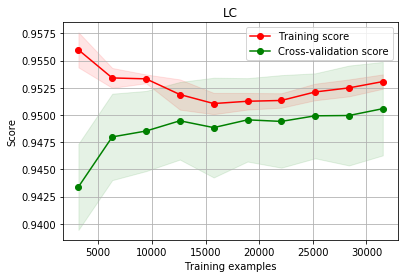

In [28]:
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure()
    plt.title('LC')
    
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        pipeline, features_train, labels_train, cv=10, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
